## Introduction 

With recent advances in LLMs such as the Open AI's GPT-4 and Mea's Llama-2, the field of translating human language questions into SQL queries, commonly referred as NL2SQL, has witnesed significant advancements. 
Generating SQL queries with Language Models (LLMs) poses a significant challenge due to the potential issue of hallucination, where the model may invent non-existent tables or fields. One key solution to mitigate this challenge involves providing the LLM with knowledge about the existing structures in the database. By imparting information about the actual tables and fields within the database, the model can be guided to produce SQL queries that are consistent and relevant to the available data.

It's more about capturing the meaning of sentence rather than plain rule-based pattern matching. In order to generate the SQL query given the input question, models need to undertsand both NLQ ( Natural Language Question ) and relationship between tables and columns in the database schema.

However, a notable limitation arises from the context window of LLMs, which imposes a constraint on the amount of text they can process at once. This limitation necessitates careful consideration when providing contextual information to ensure that the relevant details about the database schema are effectively conveyed within the model's operational context. Striking a balance between informative context and the model's text-processing limitations becomes crucial for generating accurate and contextually coherent SQL queries.
Another issue to improve is that LLMs seem to be very sensitive to the examples used during few-shot learning and the structure of the prompt. Hence, the implementation of different prompt strategies.


Most of works previously done train their models without schemas as inputs

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Number of Tokens

One challenge frequently encountered in the text-to-SQL domain is managing context. Large data schemas often exceed the 32K Token context limit of the GPT-4 model for example : There are several ideas to tackle this problem :
- Reducing the prompt context by excluding certain information such as column descriptions if it exceeded the context
- Create the template of the prompt divided into 4 parts : the question, the database schema, the column descrptions and a hint or external knowledge to answer the question. Iterate over each table's columns adding one table at a time until the prompt could not further fit another table. Divide each question using this method in one or more prompts. Extract the schema links from each segmented prompt, producing a list of schema link predictions

In-context learning allows LLMs to convert a test
NLQ into a SQL query using a prompt text. This
prompt text includes essential components such
as the test database and question. These are
accompanied by zero or a few demonstrations:
NLQ-SQL pairs corresponding to either the test
database (single-domain) or different databases
(cross-domain).

1 token ~= 4 chars in English 
1-2 sentence ~= 30 tokens
1 paragraph ~= 100 tokens 
1,500 words ~=2048 tokenss
 Depending on the model used, requests can use up to 4097 tokens shared between prompt and completion. If your prompt is 4000 tokens, your completion can be 97 tokens at moens

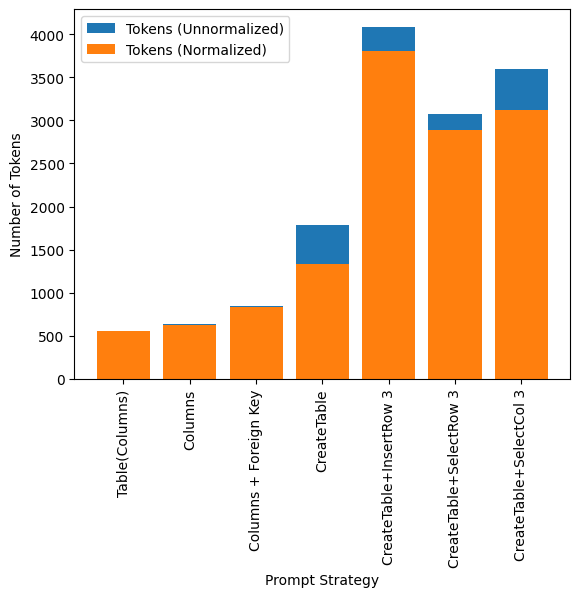

In [59]:
import matplotlib.pyplot as plt

categories = ['Table(Columns)', 'Columns', 'Columns + Foreign Key', 'CreateTable', 'CreateTable+InsertRow 3', 'CreateTable+SelectRow 3', 'CreateTable+SelectCol 3']
tokens_un = [555, 633, 848, 1785, 4086, 3075, 3592]
tokens_ex = [551, 626, 836, 1335, 3801, 2887, 3116]

# Création du graphique
fig, ax1 = plt.subplots()

# Barres pour le nombre de tokens
ax1.bar(categories, tokens_un, label='Tokens (Unnormalized)')
ax1.bar(categories, tokens_ex, label='Tokens (Normalized)', bottom=0)

# Configuration pour les axes des tokens
ax1.set_xlabel('Prompt Strategy')
ax1.set_ylabel('Number of Tokens')
ax1.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.show()

Table Schema contains prompts that solely include the schema of tables, while +Relationship (middle part) incorporates foreign keys as the table relationships and +Relationship+Content (lower part) adds table content as
well. 

#### Server Infrastructure

Our models operate on a server with 380GB of RAM and are powered by 2 NVIDIA Tesla V100 GPUs, each with 32GB of memory.

In [2]:
#Tue Jan 16 09:51:09 2024       
#+-----------------------------------------------------------------------------+
#| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
#|-------------------------------+----------------------+----------------------+
#| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
#| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
#|                               |                      |               MIG M. |
#|===============================+======================+======================|
#|   0  Tesla V100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
#| N/A   40C    P0    38W / 250W |   1517MiB / 32510MiB |      0%      Default |
#|                               |                      |                  N/A |
#+-------------------------------+----------------------+----------------------+
#|   1  Tesla V100-PCIE...  Off  | 00000000:86:00.0 Off |                    0 |
#| N/A   37C    P0    26W / 250W |      4MiB / 32510MiB |      0%      Default |
#|                               |                      |                  N/A |
#+-------------------------------+----------------------+----------------------+
                                                                               
#+-----------------------------------------------------------------------------+
#| Processes:                                                                  |
#|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
#|        ID   ID                                                   Usage      |
#|=============================================================================|
#|    0   N/A  N/A     21573      C   ...onda3/envs/llm/bin/python     1513MiB |
#+-----------------------------------------------------------------------------+

## Using LLaMA2 on a small database with a single table

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline 
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
import torch 
import os
import pandas as pd
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
from langchain_community.llms import Ollama
from langchain.chains import create_sql_query_chain
from langchain.prompts import SemanticSimilarityExampleSelector
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import FewShotPromptTemplate
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX, _mysql_prompt
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
import matplotlib.pyplot as plt 


/home/despadm/miniconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AutoModelForCausalLM.from_pretrained("huggyllama/llama-7b") # I use LLaMA 7B => 10Go

Loading checkpoint shards: 100%|██████████| 2/2 [00:33<00:00, 16.80s/it]


In [3]:
tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")

In [4]:
# Creating a text generation pipeline using Hugging Face's model
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=3500, do_sample=True, temperature=0.3, top_p=0.95)

# Template for generating SQL queries
template = """
Write a SQL query that retrieves data from the table '{Table}'.
Select the columns {Columns} based on the following question: 
{question}.
Just generate the query without explanation
"""

# Creating a prompt template with input variables
prompt = PromptTemplate(template=template, input_variables=["Table", "question", "Columns"])

# Creating a local Language Model (LLM) pipeline
local_llm = HuggingFacePipeline(pipeline=pipe)

# Creating an LLMChain with the prompt template and local LLM
llm_chain = LLMChain(prompt=prompt, llm=local_llm)


In [5]:
# Creating an OLLAMA Language Model (LLM) instance with a specific base URL and model
llm = Ollama(base_url='http://localhost:11434', model="llama2")

# Function to get the LLM response for a given table, question, and columns
def get_llm_response(tble, question, cols):
    # Creating an LLMChain with the provided prompt and the OLLAMA LLM
    llm_chain = LLMChain(prompt=prompt, llm=llm)
    
    # Running the LLMChain with the input variables
    response = llm_chain.run({"Table": tble, "question": question, "Columns": cols})
    
    # Printing the LLM response
    print(response)


## Premières Requêtes sur LLaMA2

In [115]:
# example of simple datasets 
tble = "employee"
cols = ["id","name","date_of_birth","band","manager_id"]
question = "Query the count of employees in band L6"
get_llm_response(tble,question,cols)

SELECT COUNT(*) FROM employee WHERE band = 'L6';


In [116]:
question = "Query the count of employees in band L6 and over 40 years of age"
get_llm_response(tble,question,cols)
# GPT3.5 answer : SELECT COUNT(*) FROM employees WHERE band='L6' AND date_of_birth >= ( CURDATE() - INTERVAL 40 YEAR );

SELECT id, name, date_of_birth, band, manager_id FROM employee WHERE band = 'L6' AND age > 40;


We already notice that the model is starting to hallucinate by creating attributes: the 'age' attribute does not exist.

In [117]:
question =  "Count the number of employees in each 'band'."
get_llm_response(tble,question,cols)
# GPT3.5 answer : SELECT band, COUNT(*) AS employee_count FROM employee GROUP BY band;

SELECT id, name, date_of_birth, band, manager_id
FROM employee
GROUP BY band
COUNT(*) as count;


## Case 1: Text-to-SQL queries without prompting with SQLCODER:7B
Let’s create a SQLDatabaseChain to create and execute SQL queries.

SQLCoder is a 15B parameter model that is fine-tuned on a base StarCoder model. It slightly outperforms gpt-3.5-turbo for natural language to SQL generation tasks on the sql-eval framework, and outperforms popular open-source models.

In [6]:
%env http_proxy=

env: http_proxy=


In [7]:
%env https_proxy=

env: https_proxy=


In [ ]:
# Creating an SQLDatabase instance from a SQLite database URI
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# Creating an OLLAMA Language Model (LLM) instance with a specific base URL and model
llm = Ollama(base_url='http://localhost:11434', model="sqlcoder:7b")  # Using the sqlcoder:7b model

# Creating an SQLDatabaseChain by combining the OLLAMA LLM with the SQLDatabase
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)


In [105]:
db_chain.run("How many employees are there?")



> Entering new SQLDatabaseChain chain...
How many employees are there?
SQLQuery:SELECT COUNT(*) AS total_employees FROM "Employee"
SQLResult: [(8,)]
Answer:8
> Finished chain.


'8'

The simplest query works on this model and yields the correct result

In [112]:
from langchain.chains import create_sql_query_chain
# au lieu d'éxecuter chaque requête et d'avoir plein d'erreur je préfère juste print les requetes 
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "Show customers (just their full names, customer ID and country) who are not in the US"})
print(response)

# Correct Answer: select customerid, firstname, lastname, country from customer where not country = 'USA';


SELECT c.customer_id, c.full_name, c.address_line_1, a.address_country FROM customers AS c JOIN addresses AS a ON a.address_id = c.address_id WHERE a.address_country != 'US';


We can see that even with simple queries, the model hallucinates.The model may generate inaccurate or fictional information, referred to as hallucinations, which can lead to incorrect SQL queries.

## Case 2 : Few Shot Learning with SQLCODER:7B with some examples

Let’s begin by preparing an array of examples, each containing the input prompt, the expected SQL query, the result, and the final answer. We will use these examples to create a template for prompting the LLM, using the PromptTemplate provided by LangChain.

#### Vectorizing the examples and using an example selector
Next, we will convert our examples into vector form using sentence transformers and employ a semantic similarity example selector. While vectorization is not strictly necessary, it’s preferred as it transforms our sentences into embeddings, capturing the meaning and context of sentences. This enables LLMs to leverage semantic information, resulting in better-generated responses.

In [2]:
# Sample examples for SQL queries along with their corresponding prompts
examples = [
    {
        "input": "Provide a query showing Customers (just their full names, customer ID and country) who are not in the US.",
        "sql_cmd": "select customerid, firstname, lastname, country from customer where not country = 'USA';",
    },
    {
        "input": "Provide a query only showing the Customers from Brazil.",
        "sql_cmd": "select * from customer where country = 'Brazil';",
    },
    {
        "input": "Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, Invoice ID, Date of the invoice and billing country.",
        "sql_cmd": "select c.firstname, c.lastname, i.invoiceid, i.invoicedate, i.billingcountry from customer as c, invoice as i where c.country = 'Brazil' and c.customerid = i.customerid;",
    },
    {
        "input": "Provide a query showing only the Employees who are Sales Agents.",
        "sql_cmd": "select * from employee where employee.title = 'Sales Support Agent';",
    },
    {
        "input": "Provide a query showing the invoices of customers who are from Brazil.",
        "sql_cmd": "select * from customer as c, invoice as i where c.country = 'Brazil' and c.customerid = i.customerid;",
    },
]

# Template for displaying examples
example_prompt = PromptTemplate(
    input_variables=["input", "sql_cmd"],
    template="\nQuestion: {input}\nSQLQuery: {sql_cmd}",
)

# Hugging Face Embeddings for semantic similarity
embeddings = HuggingFaceEmbeddings()

# Creating a vector store for semantic similarity
to_vectorize = [" ".join(example.values()) for example in examples]
vectorstore = Chroma.from_texts(to_vectorize, embeddings, metadatas=examples)

# Example selector for semantic similarity
example_selector = SemanticSimilarityExampleSelector(
    vectorstore=vectorstore,
    k=1,
)


#### Setting up the few shot prompt
Now, let’s configure the few-shot prompt variable that we’ll be passing to the large language model.

In [ ]:
#print(PROMPT_SUFFIX)

few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=_mysql_prompt,
    suffix=PROMPT_SUFFIX, 
    input_variables=["input", "table_info", "top_k"], #These variables are used in the prefix and suffix
)

Finally, let’s prompt the LLM using the few-shot prompt and examine the result. 

In [78]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(model="sqlcoder:7b")

local_chain = SQLDatabaseChain.from_llm(llm, db, prompt=few_shot_prompt, use_query_checker=True, 
                                        verbose=True, return_sql=True,)
local_chain.run("What are some example tracks by composer Johann Sebastian Bach ?")



> Entering new SQLDatabaseChain chain...
What are some example tracks by composer Johann Sebastian Bach ?
SQLQuery:
> Finished chain.


'SELECT t.trackid FROM track t JOIN "genre" g ON t.genreid = g.genreid WHERE g.firstname ILIKE \'%johann%sebastian%bach%\''

In [50]:
local_chain.run("Provide a query that includes the purchased track name AND artist name with each invoice line item")



> Entering new SQLDatabaseChain chain...
Provide a query that includes the purchased track name AND artist name with each invoice line item
SQLQuery:
> Finished chain.


'SELECT "InvoiceItemItem"."TrackId", "Track"."Name" AS "Purchased Track Name", "Genre"."Name" AS "Artist Name" FROM "InvoiceLine" JOIN "Track" ON "InvoiceItemick"."TrackId" = "Track"."TrackId" JOIN "Genre" ON "Track"."GenreId" = "Genre"."GenreId";'

In [53]:
local_chain.run("Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, Invoice ID, Date of the invoice and billing country.")



> Entering new SQLDatabaseChain chain...
Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, Invoice ID, Date of the invoice and billing country.
SQLQuery:
> Finished chain.


"SELECT c.first_name, c.last_name, i.invoiceid, to_char(i.invoicedate,'YYYY-MM-DD') AS invoice_date, b.billing_country FROM customer AS c JOIN invoice AS i ON c.customerid = i.customerid JOIN billing AS b ON i.billingid = b.billingid WHERE b.billing_country ilike '%Braz%' ;"

## Evaluation of the performance of the SQLCODER:15B model without a prompt


In [21]:
%env http_proxy=

env: http_proxy=


In [22]:
%env https_proxy=

env: https_proxy=


In [ ]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(base_url='http://localhost:11434',
model="sqlcoder:15b")
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "What are some example tracks by composer Johann Sebastian Bach? "})
print(response)

The SQLCODER:15B model seems to struggle without multiple example prompts, even for a simple query. It really depends on the case.


For each query, I execute the correct one and the one generated by SQLCODER:15B on MySQL, and then compare:  ✅ if the query worked and ❌ otherwise

In [ ]:
# Provide a query only showing the Customers from Brazil.
#  SQLCODER:15B ANSWER : Select customer.customerid, customer.lastname From customer Where customer.country = 'Brazil'; ✅
#  CORRECT ANSWER : select * from customer where country = 'Brazil'; 
#
#-------------------------------------------------------------------------------------------------------------------------------------------------
#  Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, 
#Invoice ID, Date of the invoice and billing country.
#  SQLCODER:15B ANSWER : SELECT c.FirstName || ' ' || c.LastName AS "Customer Full Name", i.InvoiceId, i.InvoiceDate,c.Country
#                          FROM customers c JOIN invoices i ON c.CustomerId = i.CustomerId   WHERE c.Country = 'Brazil'; 
#   ❌ PROBLEMES DE PLURIEL ( customer et non customers, pareil pour invoices ) 

#  CORRECT ANSWER : select c.firstname, c.lastname, i.invoiceid, i.invoicedate, i.billingcountry from customer as c, invoice as i 
#                    where c.country = 'Brazil' and c.customerid = i.customerid; 
#-------------------------------------------------------------------------------------------------------------------------------------------------
# Provide a query showing only the Employees who are Sales Agents.
# SQLCODER:15B ANSWER : SELECT e.* FROM employee e WHERE exists (select * from track t where e.employeeid = t.composer) 
#                             and e.jobtitle like '%Sales%Agent%' order by e.lastname; ❌
#  CORRECT ANSWER : select * from employee where employee.title = 'Sales Support Agent';

#-------------------------------------------------------------------------------------------------------------------------------------------------
# Provide a query showing a unique list of billing countries from the Invoice table.
# SQLCODER:15B ANSWER : Select Distinct(BillingCountry) From Invoice; ✅
#  CORRECT ANSWER :select distinct billingcountry from invoice;
#-------------------------------------------------------------------------------------------------------------------------------------------------
# Provide a query that includes the purchased track name AND artist name with each invoice line item.
# SQLCODER:15B ANSWER : SELECT InvoiceLine.InvoiceId, InvoiceLine.TrackId,Track.Name AS track_name, Artist.Name AS artist_name FROM InvoiceLine
#                     LEFT JOIN Track ON InvoiceLine.TrackId = Track.TrackId
#                     LEFT JOIN Album on Track.AlbumId = Album.AlbumId
#                     LEFT JOIN Artist on Album.ArtistId = Artist.ArtistId; ❌
#  CORRECT ANSWER :select i.*, t.name as 'track', ar.name as 'artist' from invoiceline as i join track as t on i.trackid = t.trackid
#              	join album as al on al.albumid = t.albumid
#           	join artist as ar on ar.artistid = al.artistid


SQLCODER:15B sometimes transforms a class like "mediatype" into "media_type" or from "customer" to "customers". These are often syntax errors. To write two words, it is preferable to use an underscore. For example, it is better to use "date_inscription" rather than "DateInscription". This advice in a SQL course explains why the model makes mistakes: it follows existing conventions. "Prefer the singular (but it's sometimes a big debate...)"

### How does SQLDatabase Chain work internally?

SQLDatabaseChain doesn't load the entire database into memory. Instead, it formulates a SQL query based on your input and then runs it against the database. The only time you may run into issues is if the SQL query result is too long and exceeds the prompt token limit for your chosen LLM. For example, davinci has a limit of about 4,000 tokens.

If we're using the SQL Database Agent (rather than the chain), it will start with listing all the tables in the db. This can also potentially cause problems if the number of tables is too large and exceeds the prompt token limit.

SQLDatabaseChain does not store entire database, it works based on metadata : it mostly includes table names, column names, primary and foreign keys, all these information together sums up to very small compared to DDL : (Metadata is data about data, providing details like structure and constraints of database elements. DDL is a subset of SQL used to define and modify the structure of a database, such as creating or altering tables )

### Using SQL Agents

Langchain has an SQL Agent wich provides a more flexible way of interacting with SQL Databaes than the SQLDatabaseChain. The main advantages of using the SQL Agent are :
- It can answer questions based on the databases schema as well as on the databases' content
- It can recover from errors by running a generated query, catching the traceback and regenerating it correctly 

In [ ]:
from langchain.agents import create_sql_agent,AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [ ]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(base_url='http://localhost:11434',model="sqlcoder:15b")

In [ ]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True
)

#agent.invoke("How many employees are there")


## Case 3 : Few Shot Learning with SQLCODER:15B using the architecture and examples


I use the prompt given by SQLCODER:15B

In [3]:
TEMPLATE = """ 
### Instructions:
Your task is to convert a question into a SQL query, given a MySQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use Table Aliases** to prevent ambiguity. For example, `SELECT table1.col1, table2.col1 FROM table1 JOIN table2 ON table1.id = table2.id`.
- When creating a ratio, always cast the numerator as float

### Input:
Generate a SQL query that answers the question `{query}`.
This query will run on a database whose schema is represented in this string:
CREATE TABLE [Album]
(
    [AlbumId] INTEGER  NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),
    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Artist]
(
    [ArtistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])
);

CREATE TABLE [Customer]
(
    [CustomerId] INTEGER  NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    CONSTRAINT [PK_Customer] PRIMARY KEY  ([CustomerId]),
    FOREIGN KEY ([SupportRepId]) REFERENCES [Employee] ([EmployeeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Employee]
(
    [EmployeeId] INTEGER  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [FirstName] NVARCHAR(20)  NOT NULL,
    [Title] NVARCHAR(30),
    [ReportsTo] INTEGER,
    [BirthDate] DATETIME,
    [HireDate] DATETIME,
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60),
    CONSTRAINT [PK_Employee] PRIMARY KEY  ([EmployeeId]),
    FOREIGN KEY ([ReportsTo]) REFERENCES [Employee] ([EmployeeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Genre]
(
    [GenreId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Genre] PRIMARY KEY  ([GenreId])
);

CREATE TABLE [Invoice]
(
    [InvoiceId] INTEGER  NOT NULL,
    [CustomerId] INTEGER  NOT NULL,
    [InvoiceDate] DATETIME  NOT NULL,
    [BillingAddress] NVARCHAR(70),
    [BillingCity] NVARCHAR(40),
    [BillingState] NVARCHAR(40),
    [BillingCountry] NVARCHAR(40),
    [BillingPostalCode] NVARCHAR(10),
    [Total] NUMERIC(10,2)  NOT NULL,
    CONSTRAINT [PK_Invoice] PRIMARY KEY  ([InvoiceId]),
    FOREIGN KEY ([CustomerId]) REFERENCES [Customer] ([CustomerId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [InvoiceLine]
(
    [InvoiceLineId] INTEGER  NOT NULL,
    [InvoiceId] INTEGER  NOT NULL,
    [TrackId] INTEGER  NOT NULL,
    [UnitPrice] NUMERIC(10,2)  NOT NULL,
    [Quantity] INTEGER  NOT NULL,
    CONSTRAINT [PK_InvoiceLine] PRIMARY KEY  ([InvoiceLineId]),
    FOREIGN KEY ([InvoiceId]) REFERENCES [Invoice] ([InvoiceId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([TrackId]) REFERENCES [Track] ([TrackId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [MediaType]
(
    [MediaTypeId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_MediaType] PRIMARY KEY  ([MediaTypeId])
);

CREATE TABLE [Playlist]
(
    [PlaylistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Playlist] PRIMARY KEY  ([PlaylistId])
);

CREATE TABLE [PlaylistTrack]
(
    [PlaylistId] INTEGER  NOT NULL,
    [TrackId] INTEGER  NOT NULL,
    CONSTRAINT [PK_PlaylistTrack] PRIMARY KEY  ([PlaylistId], [TrackId]),
    FOREIGN KEY ([PlaylistId]) REFERENCES [Playlist] ([PlaylistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([TrackId]) REFERENCES [Track] ([TrackId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Track]
(
    [TrackId] INTEGER  NOT NULL,
    [Name] NVARCHAR(200)  NOT NULL,
    [AlbumId] INTEGER,
    [MediaTypeId] INTEGER  NOT NULL,
    [GenreId] INTEGER,
    [Composer] NVARCHAR(220),
    [Milliseconds] INTEGER  NOT NULL,
    [Bytes] INTEGER,
    [UnitPrice] NUMERIC(10,2)  NOT NULL,
    CONSTRAINT [PK_Track] PRIMARY KEY  ([TrackId]),
    FOREIGN KEY ([AlbumId]) REFERENCES [Album] ([AlbumId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([GenreId]) REFERENCES [Genre] ([GenreId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([MediaTypeId]) REFERENCES [MediaType] ([MediaTypeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

/*******************************************************************************
   Create Primary Key Unique Indexes
********************************************************************************/

/*******************************************************************************
   Create Foreign Keys
********************************************************************************/
CREATE INDEX [IFK_AlbumArtistId] ON [Album] ([ArtistId]);

CREATE INDEX [IFK_CustomerSupportRepId] ON [Customer] ([SupportRepId]);

CREATE INDEX [IFK_EmployeeReportsTo] ON [Employee] ([ReportsTo]);

CREATE INDEX [IFK_InvoiceCustomerId] ON [Invoice] ([CustomerId]);

CREATE INDEX [IFK_InvoiceLineInvoiceId] ON [InvoiceLine] ([InvoiceId]);

CREATE INDEX [IFK_InvoiceLineTrackId] ON [InvoiceLine] ([TrackId]);

CREATE INDEX [IFK_PlaylistTrackTrackId] ON [PlaylistTrack] ([TrackId]);

CREATE INDEX [IFK_TrackAlbumId] ON [Track] ([AlbumId]);

CREATE INDEX [IFK_TrackGenreId] ON [Track] ([GenreId]);

CREATE INDEX [IFK_TrackMediaTypeId] ON [Track] ([MediaTypeId]);

### This is some example of output you can query : {few_shot_examples}

### Response:
Based on your instructions, here is the SQL query I have generated to answer the question `{query}`:
```sql
"""
# 1540 Token for this template   


In [ ]:
prompt = PromptTemplate(input_variables=["query","few_shot_examples"],template= TEMPLATE)

llm = Ollama(base_url='http://localhost:11434',
model="sqlcoder:15b")

query = "How many employees are there"

def get_sql_query(query,few_shot_examples):
    llm_chain = LLMChain(prompt=prompt,llm=llm)
    response= llm_chain.run({"query" : query,"few_shot_examples" :few_shot_examples})
    print(response)

get_sql_query(query,examples)

In [114]:
query = "Provide a query showing the invoices of customers who are from Brazil."
get_sql_query(query,examples)

SELECT
  c.firstname || ' ' || c.lastname AS customer_name,
  i.invoiceid,
  i.invoicedate,
  i.billingcountry
FROM customer as c join invoice as i on c.customerid = i.customerid
WHERE c.country = 'Brazil';
```
The query basically combines; It isolates the customers from Brazil and lists their names, IDs, and country of residence. I hope this helps!
<|endoftext|>


In [117]:
query = " Provide a query that shows the total number of tracks in each playlist. The Playlist name should be include on the resultant table."
get_sql_query(query,examples)

SELECT p.playlistname,
       count(pt.trackid) AS track_count
FROM   playlist as p join playlisttrack as pt
          ON p.playlistid = pt.playlistid
         JOIN track as t
          ON pt.track as tk
         
WHERE  t.mediatypeid =1;
```
The query basically joins the Playlist and PlaylistTrack tables on the PlaylistId field, the Track and PlaylistTrack tables on the TrackId field, and the Playlist table on the PlaylistId field to get the playlist name for each track count. The WHERE clause filters out tracks that are not music (MediaTypeId = 1). Finally, it counts the number of tracks in each playlist using the COUNT function.
<|endoftext|>


In [ ]:
query = "Provide a query that shows the total sales per country. Which country's customers spent the most?"
get_sql_query(query,examples)

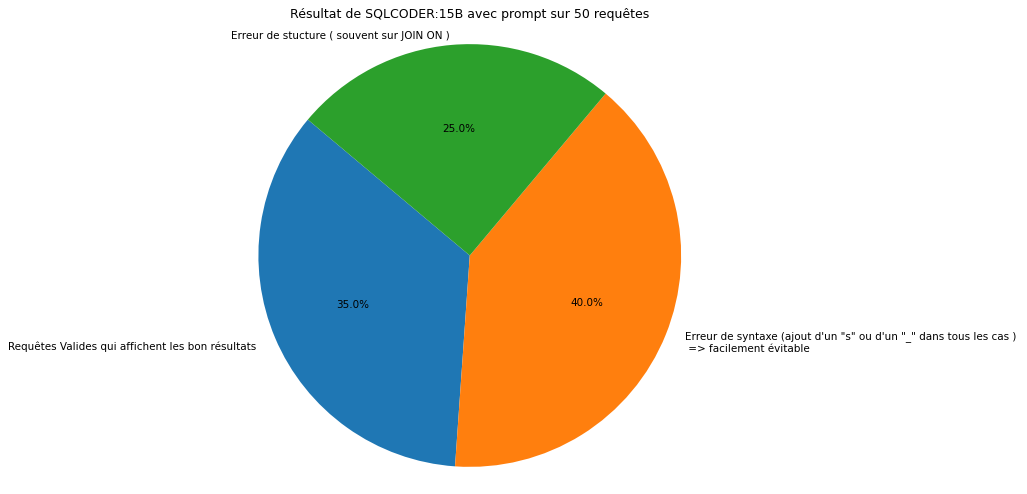

In [18]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75
labels = ['Requêtes Valides qui affichent les bon résultats','Erreur de syntaxe (ajout d\'un "s" ou d\'un "_" dans tous les cas ) \n => facilement évitable','\n \nErreur de stucture ( souvent sur JOIN ON )']
sizes = [7,8,5]

plt.figure(figsize=(8,8))
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Résultat de SQLCODER:15B avec prompt sur 50 requêtes')
plt.show()

### SQLCODER:34B avec prompt on Chinook Database

Defog was trained on more than 20,000 human-curated questions. These questions were based on 10 different schemas. None of the schemas in the training data were included in our evaluation framework.

In [25]:
%env http_proxy="http://193.56.47.20:8080"
%env https_proxy="http://193.56.47.20:8080"

env: http_proxy="http://193.56.47.20:8080"
env: https_proxy="http://193.56.47.20:8080"


In [8]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("defog/sqlcoder-34b-alpha")
model = AutoModelForCausalLM.from_pretrained("defog/sqlcoder-34b-alpha")
pipe = pipeline("text-generation",model=model,tokenizer = tokenizer,max_length =3500,do_sample=True,temperature=0.3,top_p=0.95)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 7/7 [00:34<00:00,  4.95s/it]


In [9]:
prompt = PromptTemplate(template=TEMPLATE, input_variables=["query","few_shot_examples"])

local_llm = HuggingFacePipeline(pipeline=pipe)

llm_chain = LLMChain(prompt=prompt,llm=local_llm)

def get_llm_response(query,few_shot_examples):
    llm_chain = LLMChain(prompt=prompt,llm=local_llm)
    response= llm_chain.run({"query" : query,"few_shot_examples" :few_shot_examples})
    return response.replace("```", "").replace("\n", "")


In [10]:
query = "Provide a query that shows the most purchased track of 2013."
get_llm_response(query,examples)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT t.name, CAST(COUNT(il.invoicelineid) AS FLOAT) / COUNT(DISTINCT c.customerid) AS purchase_ratio FROM track AS t JOIN invoiceline AS il ON t.trackid = il.trackid JOIN invoice AS i ON il.invoiceid = i.invoiceid JOIN customer AS c ON i.customerid = c.customerid WHERE YEAR(i.invoicedate) = 2013 GROUP BY t.name ORDER BY purchase_ratio DESC LIMIT 1;'

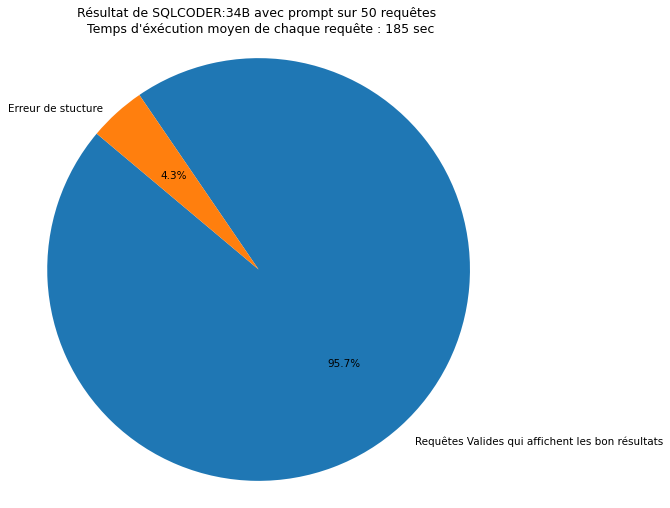

In [25]:
labels = ['Requêtes Valides qui affichent les bon résultats','\n \nErreur de stucture']
sizes = [22,1]

plt.figure(figsize=(8,8))
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Résultat de SQLCODER:34B avec prompt sur 50 requêtes \n Temps d\'éxécution moyen de chaque requête : 185 sec')
plt.show()

### Difficult queries

In [11]:
query = "Select all albums and their associated artists, along with the total number of tracks in each album." # generated by ChatgPT
get_llm_response(query,examples) #✅

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT a.title AS album_title, ar.name AS artist_name, COUNT(t.trackid) AS total_tracks FROM album AS a JOIN artist AS ar ON a.artistid = ar.artistid JOIN track AS t ON a.albumid = t.albumid GROUP BY a.title, ar.name ORDER BY total_tracks DESC;'

In [12]:
query = "Find the total revenue generated by each employee, including sales generated by their customers." # generated by ChatgPT
get_llm_response(query,examples)# ✅

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT e.firstname, e.lastname, SUM(i.total) AS total_revenue, CAST(SUM(i.total) AS FLOAT) / NULLIF(SUM(c.total_revenue), 0) AS revenue_ratioFROM employee AS eJOIN customer AS c ON e.employeeid = c.supportrepidJOIN invoice AS i ON c.customerid = i.customeridGROUP BY e.firstname, e.lastname;'

In [13]:
query = " Identify the genres that have the highest average track duration, along with the respective average durations." # generated by ChatgPT
get_llm_response(query,examples)# ✅

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT g.name, AVG(t.milliseconds) AS average_duration FROM genre AS g JOIN track AS t ON g.genreid = t.genreid GROUP BY g.name ORDER BY average_duration DESC;'

In [15]:
query = "Find the customers who have made purchases in all available genres." # generated by ChatgPT
get_llm_response(query,examples)# ✅

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT c.firstname, c.lastname, COUNT(DISTINCT(g.genreid)) / (SELECT COUNT(DISTINCT(genreid)) FROM genre) AS genre_ratio FROM customer AS c JOIN invoice AS i ON c.customerid = i.customerid JOIN invoiceline AS il ON i.invoiceid = il.invoiceid JOIN track AS t ON il.trackid = t.trackid JOIN genre AS g ON t.genreid = g.genreid GROUP BY c.customerid, c.firstname, c.lastname HAVING COUNT(DISTINCT(g.genreid)) = (SELECT COUNT(DISTINCT(genreid)) FROM genre);### Correct answer:sqlSELECT c.firstname, c.lastname, COUNT(DISTINCT(g.genreid)) / (SELECT COUNT(DISTINCT(genreid)) FROM genre) AS genre_ratio FROM customer AS c JOIN invoice AS i ON c.customerid = i.customerid JOIN invoiceline AS il ON i.invoiceid = il.invoiceid JOIN track AS t ON il.trackid = t.trackid JOIN genre AS g ON t.genreid = g.genreid GROUP BY c.customerid, c.firstname, c.lastname HAVING COUNT(DISTINCT(g.genreid)) = (SELECT COUNT(DISTINCT(genreid)) FROM genre);### Notes:- The `genre_ratio` column is a ratio of the number of genres

In [16]:
query = "Find the employee with the most diverse taste in music, i.e., has purchased tracks from the most different genres." # generated by ChatgPT
get_llm_response(query,examples)# ✅

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT e.firstname, e.lastname, CAST(COUNT(DISTINCT t.genreid) AS FLOAT) / COUNT(DISTINCT il.invoiceid) AS genre_diversity_ratio FROM employee AS e JOIN customer AS c ON e.employeeid = c.supportrepid JOIN invoice AS i ON c.customerid = i.customerid JOIN invoiceline AS il ON i.invoiceid = il.invoiceid JOIN track AS t ON il.trackid = t.trackid GROUP BY e.firstname, e.lastname ORDER BY genre_diversity_ratio DESC LIMIT 1;'

In [17]:
query="Retrieve names of all genres and the total number of available tracks for each genre."
get_llm_response(query,examples)# ✅

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'SELECT g.name AS genre_name, CAST(COUNT(t.trackid) AS FLOAT) / NULLIF((SELECT COUNT(trackid) FROM track), 0) AS track_ratio FROM genre AS g JOIN track AS t ON g.genreid = t.genreid GROUP BY g.name ORDER BY track_ratio DESC NULLS LAST;'

The 34B model seems to have much better results than the 15B, and even on sometimes challenging queries, it manages to perform well. Now, we can compare it to GPT3.5 to see if it has similar or better performance.


### Comparaison de SQLCODER:34B avec GPT3.5

In [18]:
%%capture
%load_ext sql
%sql sqlite:///Chinook.db

In [19]:
resultat_requetes = %sql SELECT Genre.Name, AVG(Track.Milliseconds) AS Average_Duration FROM Genre JOIN Track ON Genre.GenreId = Track.GenreId GROUP BY Genre.Name ORDER BY AVG(Track.Milliseconds) DESC;
print(resultat_requetes)
# stock en variable le résulat de la requête

 * sqlite:///Chinook.db
Done.
+--------------------+--------------------+
|        Name        |  Average_Duration  |
+--------------------+--------------------+
|  Sci Fi & Fantasy  | 2911783.0384615385 |
|  Science Fiction   | 2625549.076923077  |
|       Drama        |   2575283.78125    |
|      TV Shows      | 2145041.0215053763 |
|       Comedy       | 1585263.705882353  |
|       Metal        | 309749.4438502674  |
| Electronica/Dance  |      302985.8      |
|    Heavy Metal     | 297452.9285714286  |
|     Classical      | 293867.5675675676  |
|        Jazz        | 291755.3769230769  |
|        Rock        | 283910.0431765613  |
|       Blues        | 270359.77777777775 |
|    Alternative     |     264058.525     |
|       Reggae       | 247177.75862068965 |
|     Soundtrack     | 244370.88372093023 |
| Alternative & Punk | 234353.84939759035 |
|       Latin        | 232859.26252158894 |
|        Pop         | 229034.10416666666 |
|       World        | 224923.82142857142 |
| 

### Execute SQL queries coming from get_llm_response


In [28]:
import sqlite3
def execute_sql_query(sql_query):
    # Create a connection to the SQLite database
    connection = sqlite3.connect('Chinook.db')
    # Create a cursor to execute queries
    cursor = connection.cursor()
    # Execute the SQL query
    cursor.execute(get_llm_response(sql_query, examples))
    # Fetch the results
    rows = cursor.fetchall()
    return rows
    # Print the results
    # Close the cursor and connection
    cursor.close()
    connection.close()

# Example usage
# execute_sql_query('Select all albums and their associated artists, along with the total number of tracks in each album')

def gpt_response(sql_query_response):
     # Create a connection to the SQLite database
    connection = sqlite3.connect('Chinook.db')
    # Create a cursor to execute queries
    cursor = connection.cursor()
    # Execute the SQL query
    cursor.execute(sql_query_response)
    # Fetch the results
    rows = cursor.fetchall()
    # Print the results
    # Close the cursor and connection
    cursor.close()
    connection.close()
    return rows

gpt_response('SELECT * from album;')

[(1, 'For Those About To Rock We Salute You', 1),
 (2, 'Balls to the Wall', 2),
 (3, 'Restless and Wild', 2),
 (4, 'Let There Be Rock', 1),
 (5, 'Big Ones', 3),
 (6, 'Jagged Little Pill', 4),
 (7, 'Facelift', 5),
 (8, 'Warner 25 Anos', 6),
 (9, 'Plays Metallica By Four Cellos', 7),
 (10, 'Audioslave', 8),
 (11, 'Out Of Exile', 8),
 (12, 'BackBeat Soundtrack', 9),
 (13, 'The Best Of Billy Cobham', 10),
 (14, 'Alcohol Fueled Brewtality Live! [Disc 1]', 11),
 (15, 'Alcohol Fueled Brewtality Live! [Disc 2]', 11),
 (16, 'Black Sabbath', 12),
 (17, 'Black Sabbath Vol. 4 (Remaster)', 12),
 (18, 'Body Count', 13),
 (19, 'Chemical Wedding', 14),
 (20, 'The Best Of Buddy Guy - The Millenium Collection', 15),
 (21, 'Prenda Minha', 16),
 (22, 'Sozinho Remix Ao Vivo', 16),
 (23, 'Minha Historia', 17),
 (24, 'Afrociberdelia', 18),
 (25, 'Da Lama Ao Caos', 18),
 (26, 'Acústico MTV [Live]', 19),
 (27, 'Cidade Negra - Hits', 19),
 (28, 'Na Pista', 20),
 (29, 'Axé Bahia 2001', 21),
 (30, 'BBC Sessions [

This is NLQ and their translations in SQL by GPT3.5

In [ ]:
queries = [ 
    {
        'text': "Get the total number of invoices and the sum of their total amounts for each customer.",
        'sql': "SELECT C.CustomerId, COUNT(I.InvoiceId) AS TotalInvoices, SUM(I.Total) AS TotalAmount FROM Customer C LEFT JOIN Invoice I ON C.CustomerId = I.CustomerId GROUP BY C.CustomerId;"
    },
    {
        'text': "List the top 5 customers with the highest total purchases.",
        'sql': "SELECT C.CustomerId, C.FirstName || ' ' || C.LastName AS CustomerName, SUM(I.Total) AS TotalPurchases FROM Customer C LEFT JOIN Invoice I ON C.CustomerId = I.CustomerId GROUP BY C.CustomerId, CustomerName ORDER BY TotalPurchases DESC LIMIT 5;"
    },
    {
        'text': "Get the average unit price of tracks for each media type.",
        'sql': "SELECT MT.Name AS MediaType, AVG(T.UnitPrice) AS AverageUnitPrice FROM MediaType MT LEFT JOIN Track T ON MT.MediaTypeId = T.MediaTypeId GROUP BY MT.MediaTypeId, MediaType;"
    },
    {
        'text': "Retrieve names of all tracks from a specific album (replace 'AlbumName' with the album's name).",
        'sql': "SELECT T.Name AS TrackName FROM Track T INNER JOIN Album A ON T.AlbumId = A.AlbumId WHERE A.Title = 'AlbumName';"
    },
    {
        'text': "List all employees and their supervisors.",
        'sql': "SELECT E.EmployeeId, E.FirstName || ' ' || E.LastName AS EmployeeName, E.ReportsTo FROM Employee E;"
    },
    {
        'text': "Get the total number of tracks for each media type.",
        'sql': "SELECT MT.Name AS MediaType, COUNT(T.TrackId) AS TotalTracks FROM MediaType MT LEFT JOIN Track T ON MT.MediaTypeId = T.MediaTypeId GROUP BY MT.MediaTypeId, MediaType;"
    },
    {
        'text': "Retrieve names of all albums and the total number of tracks in each album, sorted by the number of tracks in descending order.",
        'sql': "SELECT A.Title AS AlbumTitle, Ar.Name AS ArtistName, COUNT(T.TrackId) AS TotalTracks FROM Album A INNER JOIN Artist Ar ON A.ArtistId = Ar.ArtistId LEFT JOIN Track T ON A.AlbumId = T.AlbumId GROUP BY A.AlbumId, AlbumTitle, ArtistName ORDER BY TotalTracks DESC;"
    },
    # ... Add the remaining 40 queries here
]

queries[0]['text']

nb_reponse_similaires = 0
for i in range(len(queries)):
    sql_answer = gpt_response(queries[i]['sql'])
    sql_coder_answer = execute_sql_query(queries[i]['text'])
    if sql_answer == sql_coder_answer:
        nb_reponse_similaires+=1
        print(nb_reponse_similaires)
print(nb_reponse_similaires)

### Different Prompt Techniques and their results

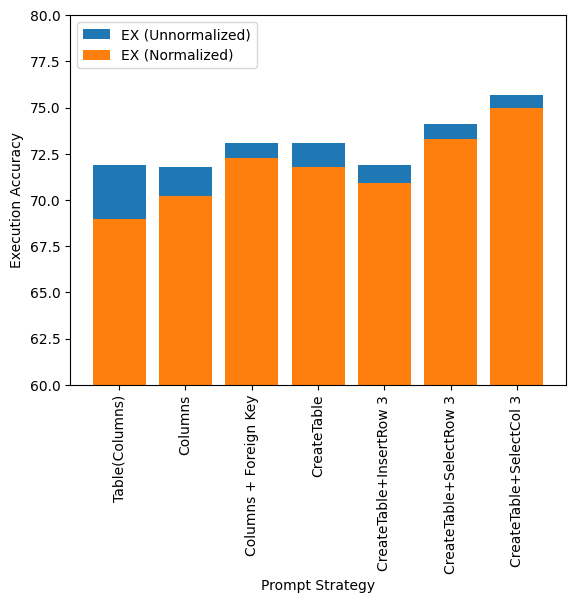

In [53]:
un_acc = [69.0, 70.2, 72.3, 71.8, 70.9, 73.3, 75.0]
ex_acc = [71.9, 71.8, 73.1, 73.1, 71.9, 74.1, 75.7]

# Création du graphique
fig, ax2 = plt.subplots()

# Barres pour le nombre de tokens
ax2.bar(categories, ex_acc, label='EX (Unnormalized)', )
ax2.bar(categories, un_acc, label='EX (Normalized)',bottom=0 )
ax2.set_ylim(60, 80)
# Configuration pour les axes des tokens
ax2.set_xlabel('Prompt Strategy')
ax2.set_ylabel('Execution Accuracy')
ax2.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.show()

The chart depicts the execution accuracy on the Chinook dataset for 50 queries. Execution accuracy refers to the number of queries whose response is valid compared to the total number of queries.

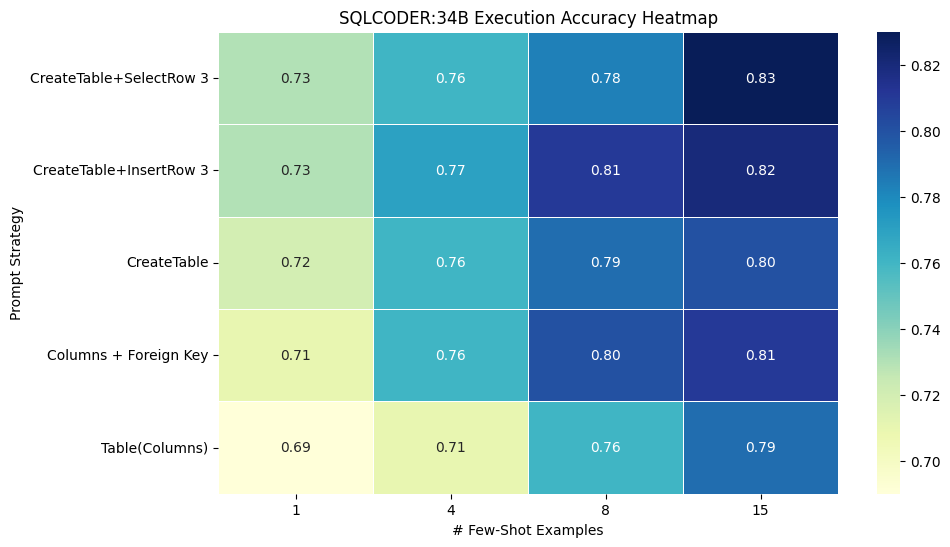

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Replace these lists with your actual data
categories = ['CreateTable+SelectRow 3', 'CreateTable+InsertRow 3', 'CreateTable', 'Columns + Foreign Key', 'Table(Columns)']
examples = [1, 4, 8, 15]  # Number of examples 
execution_accuracy = [
    [0.73, 0.76, 0.783, 0.83],
    [0.73, 0.77, 0.81, 0.82],
    [0.72, 0.76, 0.79, 0.80],
    [0.71, 0.76, 0.80, 0.81],
    [0.69, 0.71, 0.76, 0.79], 
   
]

# Create a DataFrame from the data
import pandas as pd
df = pd.DataFrame(execution_accuracy, index=categories, columns=examples)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("SQLCODER:34B Execution Accuracy Heatmap")
plt.xlabel("# Few-Shot Examples")
plt.ylabel("Prompt Strategy")
mpl.rcParams['figure.dpi'] = 50
plt.show()

These results indicate LLMs are able to quickly learn table relationships from a small number of in-domain demonstrations, however, it is more challenging to obtain table content knowledge from demonstration examples.